In [6]:
import tensorflow as tf 
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
from keras.layers import BatchNormalization, concatenate
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras import models
from keras.models import Model

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
data = pd.read_csv("Train_data.csv")
data['img'] = data['img'].apply(lambda x : x[2:])
data['label'] = data['label'].astype('category')

data = data[data.label != 2]

data['steer'] = data['steer'].apply(lambda x : np.interp(x, [-65536, 65536], [-1, 1]))
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)

image_datagen = ImageDataGenerator(rescale=1./255)

train_imgs = image_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='C:/Users/Mohamed Ali/Documents/Semester_6/Artificial_Intelligence/Project/Trackmania_Self_Driving_AI_env',
    x_col='img',
    y_col=['label', 'steer'],
    target_size=(224, 224),
    batch_size=32,
    class_mode='multi_output',
    validate_filenames=False
)
val_imgs = image_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='C:/Users/Mohamed Ali/Documents/Semester_6/Artificial_Intelligence/Project/Trackmania_Self_Driving_AI_env',
    x_col='img',
    y_col=['label', 'steer'],
    target_size=(224, 224),
    batch_size=32,
    class_mode='multi_output',
    validate_filenames=False
)
data.head()

Found 38881 non-validated image filenames.
Found 9721 non-validated image filenames.


,img,left_15,left_30,left_45,left_60,left_75,right_15,right_30,right_45,right_60,right_75,speed,label,steer
1,img_data/img_A01_arian_10.jpg,255,277,201,126,82,131,277,196,126,64,0,0,0.152100
2,img_data/img_A01_arian_20.jpg,255,277,201,126,82,131,277,196,126,64,0,0,0.152100
3,img_data/img_A01_arian_30.jpg,255,10000,201,126,84,131,113,190,126,64,1,0,0.152100
4,img_data/img_A01_arian_40.jpg,257,291,198,126,84,123,113,197,126,64,1,0,0.168411
5,img_data/img_A01_arian_50.jpg,258,280,198,126,84,125,114,193,126,64,2,0,0.168411


In [5]:
input_img = Input(shape=(224, 224, 3), name='img_input')
### 1st layer
layer_1 = Conv2D(10, (1,1), padding='same', activation='relu')(input_img)
layer_1 = Conv2D(10, (3,3), padding='same', activation='relu')(layer_1)

layer_2 = Conv2D(10, (1,1), padding='same', activation='relu')(input_img)
layer_2 = Conv2D(10, (5,5), padding='same', activation='relu')(layer_2)

layer_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
layer_3 = Conv2D(10, (1,1), padding='same', activation='relu')(layer_3)

mid_1 = concatenate([layer_1, layer_2, layer_3], axis = 3)
merged = Dropout(0.5)(mid_1)

In [8]:
flat_1 = Flatten()(merged)

classification_output = Dense(1, activation='sigmoid', name='classification_output')(flat_1)
Dense_1 = Dense(16, activation=tf.keras.layers.LeakyReLU(alpha=0.01))(flat_1)
linear_output = Dense(1, activation='linear', name='linear_output')(Dense_1)

model = Model(inputs=[input_img], outputs=[classification_output, linear_output])


In [9]:
model.compile(optimizer='adam', loss={'classification_output': 'binary_crossentropy', 'linear_output': 'mse'}, metrics=['accuracy'])

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 10  40          ['img_input[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 224, 224, 10  40          ['img_input[0][0]']              
                                )                                                             

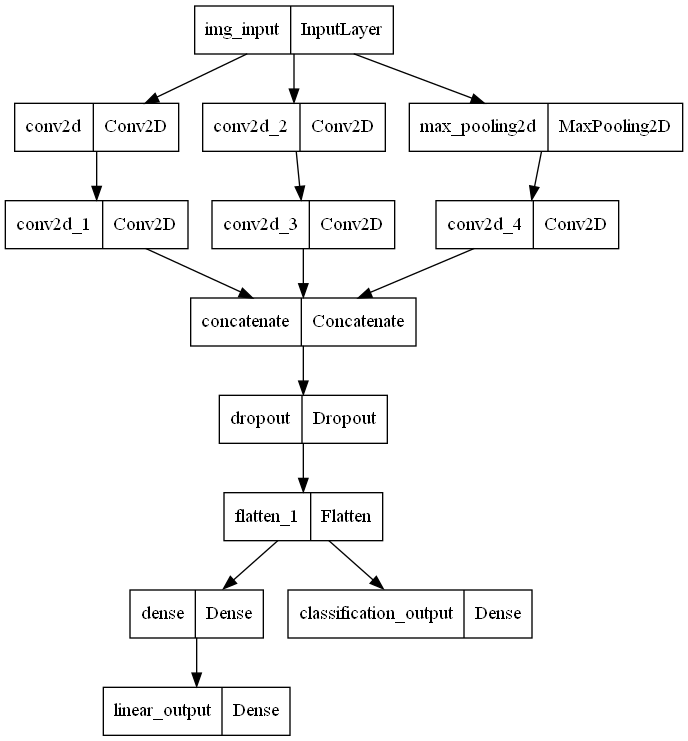

In [11]:
tf.keras.utils.plot_model(model)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint('inception_model.h5', monitor='val_accuracy', save_best_only=True, save_freq="epoch")

In [13]:
model.fit(train_imgs,
          epochs=50,
          batch_size=32,
          validation_data=val_imgs,
          callbacks=[early_stop, checkpoint])

Epoch 1/50
1216/1216 [==============================] - 2788s 2s/step - loss: 28.8937 - classification_output_loss: 0.3694 - linear_output_loss: 28.5243 - classification_output_accuracy: 0.9873 - linear_output_accuracy: 0.3624 - val_loss: 0.4392 - val_classification_output_loss: 0.2716 - val_linear_output_loss: 0.1676 - val_classification_output_accuracy: 0.9933 - val_linear_output_accuracy: 0.4031
Epoch 2/50
1216/1216 [==============================] - 2808s 2s/step - loss: 0.3077 - classification_output_loss: 0.1540 - linear_output_loss: 0.1538 - classification_output_accuracy: 0.9943 - linear_output_accuracy: 0.4112 - val_loss: 0.3677 - val_classification_output_loss: 0.2519 - val_linear_output_loss: 0.1158 - val_classification_output_accuracy: 0.9942 - val_linear_output_accuracy: 0.4314
Epoch 3/50
1216/1216 [==============================] - 3045s 3s/step - loss: 0.2442 - classification_output_loss: 0.1364 - linear_output_loss: 0.1078 - classification_output_accuracy: 0.9964 - line

In [17]:
model.save_weights('./model_weights.h5')